In [ ]:
import rocket_parser as rp
import constants
import csv
import os
import path
import atmosphere as atmo
import aerodynamics as aero
import math
from scipy.integrate import solve_ivp
from scipy.optimize import minimize, differential_evolution, Bounds
import attack
import numpy as np
import json
import warnings
from collections import deque
import matplotlib.pyplot as plt

# Глобальные переменные для хранения лучших коэффициентов
best_coefficients = None
best_score = float('inf')
best_simulation_data = None
optimization_history = []
target_achieved = False  # Флаг достижения цели

# Глобальные списки для записи данных
Cbs_list = []
Cyw_list = []
Cww_list = []
Cyy_list = []
Cwy_list = []
Cwb_list = []
Csb_list = []
attack_list = []
vel_list = []
traj_list = []
alt_list = []
time_list = []
wind_list = []

rocket = "master"
parser = rp.rocket_parser(path.rocket_lib + rocket + ".json")

# Диапазоны коэффициентов согласно требованиям
COEF1_RANGE = (0.1, 4.5)    # Первый коэффициент: 0.1 - 4.5
COEF2_RANGE = (0.02, 0.50)   # Второй коэффициент: 0.01 - 0.5

# Целевые параметры
TARGET_VELOCITY = 7780
TARGET_ALTITUDE_MIN = 198000
TARGET_ALTITUDE_MAX = 210000
TARGET_ANGLE_RANGE = 7
TARGET_FINAL_ATTACK_MIN = 1  # Минимальный финальный угол атаки

def check_target_achieved(final_velocity, final_altitude, final_angle, final_attack):
    """Проверяет, достигнуты ли целевые параметры"""
    velocity_ok = final_velocity >= TARGET_VELOCITY
    altitude_ok = TARGET_ALTITUDE_MIN <= final_altitude <= TARGET_ALTITUDE_MAX
    angle_ok = abs(final_angle) <= TARGET_ANGLE_RANGE
    attack_ok = abs(final_attack) >= TARGET_FINAL_ATTACK_MIN
    
    return velocity_ok and altitude_ok and angle_ok and attack_ok

def update_rocket_json(new_coefficients):
    """Обновляет коэффициенты в JSON файле ракеты"""
    json_path = path.rocket_lib + rocket + ".json"
    
    try:
        with open(json_path, 'r', encoding='utf-8') as file:
            data = json.load(file)
        
        data["attack_coefs"] = new_coefficients
               
        with open(json_path, 'w', encoding='utf-8') as file:
            json.dump(data, file, indent=2, ensure_ascii=False)
        
        print(f"✅ Коэффициенты успешно обновлены в файле: {json_path}")
        print(f"✅ Новые коэффициенты: {new_coefficients}")
        
        return True
        
    except Exception as e:
        print(f"❌ Ошибка при обновлении JSON файла: {e}")
        return False

def improved_objective_function(coefs):
    """Улучшенная функция стоимости с проверкой достижения цели и требованием к финальному углу атаки"""
    global best_score, best_coefficients, best_simulation_data, target_achieved
    
    # Если цель уже достигнута, возвращаем наилучший score
    if target_achieved:
        return best_score
    
    # Проверка границ коэффициентов
    if not (COEF1_RANGE[0] <= coefs[0] <= COEF1_RANGE[1] and 
            COEF2_RANGE[0] <= coefs[1] <= COEF2_RANGE[1]):
        return 1000.0
    
    try:
        # Запускаем симуляцию
        score, final_params, simulation_data = run_simulation_and_evaluate_detailed(coefs)
        
        if final_params:
            final_velocity, final_altitude, final_angle, max_attack, final_attack = final_params
            
            # Проверяем, достигнута ли цель
            if check_target_achieved(final_velocity, final_altitude, final_angle, final_attack):
                target_achieved = True
                best_score = 0
                best_coefficients = coefs.copy()
                best_simulation_data = simulation_data
                
                print(f"\n🎯 ЦЕЛЕВЫЕ ПАРАМЕТРЫ ДОСТИГНУТЫ!")
                print(f"Коэффициенты: {coefs}")
                print(f"Скорость: {final_velocity:.1f} м/с")
                print(f"Высота: {final_altitude/1000:.1f} км")
                print(f"Угол траектории: {final_angle:.1f}°")
                print(f"Финальный угол атаки: {final_attack:.1f}°")
                
                # Немедленно обновляем JSON файл
                update_rocket_json(coefs.tolist() if hasattr(coefs, 'tolist') else coefs)
                
                return 0  # Идеальный score
            
            # Целевые параметры
            target_velocity = TARGET_VELOCITY
            target_altitude = 200000
            target_angle = 0
            
            # Базовые ошибки (нормализованные)
            # ОШИБКА СКОРОСТИ: строгий штраф за скорости ниже целевой, НО НЕТ ШТРАФА за скорости выше целевой
            if final_velocity < target_velocity:
                velocity_error = (target_velocity - final_velocity) / target_velocity
            else:
                velocity_error = 0  # Нет ошибки если скорость выше целевой
            
            # ОШИБКА ВЫСОТЫ: штраф за отклонение от целевого диапазона
            if final_altitude < TARGET_ALTITUDE_MIN:
                altitude_error = (TARGET_ALTITUDE_MIN - final_altitude) / TARGET_ALTITUDE_MIN
            elif final_altitude > TARGET_ALTITUDE_MAX:
                altitude_error = (final_altitude - TARGET_ALTITUDE_MAX) / TARGET_ALTITUDE_MAX
            else:
                altitude_error = 0
            
            # Ошибка угла траектории
            angle_error = min(abs(final_angle - target_angle), abs(final_angle - target_angle + 360)) / 180
            
            # ОШИБКА ПО ФИНАЛЬНОМУ УГЛУ АТАКИ: 
            # - Штраф за углы меньше минимального
            # - НУЛЕВАЯ ошибка для углов >= минимального
            # - ОТРИЦАТЕЛЬНАЯ ошибка (бонус) для углов больше 5 градусов
            if abs(final_attack) < TARGET_FINAL_ATTACK_MIN:
                attack_error = (TARGET_FINAL_ATTACK_MIN - abs(final_attack)) / TARGET_FINAL_ATTACK_MIN
            else:
                attack_error = 0  # Нет ошибки если достигнут минимум
                
                # БОНУС за большие углы атаки
                if abs(final_attack) >= 5.0:
                    # Сильный бонус за углы от 5° и выше
                    attack_error = -0.3 * (abs(final_attack) - 5.0) / 10.0
                elif abs(final_attack) >= 3.0:
                    # Средний бонус за углы от 3° до 5°
                    attack_error = -0.1 * (abs(final_attack) - 3.0) / 2.0
                elif abs(final_attack) >= 2.0:
                    # Малый бонус за углы от 2° до 3°
                    attack_error = -0.05 * (abs(final_attack) - 2.0) / 1.0
            
            # Умные веса в зависимости от прогресса
            base_score = velocity_error + 2.0 * altitude_error + 1.5 * angle_error + 0.8 * attack_error
            
            # Дополнительные штрафы
            penalties = 0
            
            # Штраф за превышение высоты (очень строгий)
            if final_altitude > target_altitude + 50000:  # >250 км
                penalties += 5.0 * ((final_altitude - target_altitude) / target_altitude)
            
            # Штраф за слишком большой угол (строгий)
            if abs(final_angle) > 45:  # Слишком вертикальный полет
                penalties += 3.0 * (abs(final_angle) / 90)
            
            # Штраф за слишком маленькую скорость (очень строгий)
            if final_velocity < 5000:
                penalties += 20.0
            
            # Штраф за слишком большую атаку (но менее строгий, так как хотим большую финальную атаку)
            if abs(max_attack) > 25:
                penalties += 1.0 * (abs(max_attack) / 25)
            
            # Штраф за падение
            if final_altitude < 0:
                penalties += 100.0
            
            # Штраф за выход за границы коэффициентов
            if not (COEF1_RANGE[0] <= coefs[0] <= COEF1_RANGE[1]):
                penalties += 50.0
            if not (COEF2_RANGE[0] <= coefs[1] <= COEF2_RANGE[1]):
                penalties += 50.0
            
            total_score = base_score + penalties
            
            # Сохраняем лучший результат
            if total_score < best_score:
                best_score = total_score
                best_coefficients = coefs.copy()
                best_simulation_data = simulation_data
                
                # Записываем в историю
                optimization_history.append({
                    'coefs': coefs.copy(),
                    'score': total_score,
                    'velocity': final_velocity,
                    'altitude': final_altitude,
                    'angle': final_angle,
                    'max_attack': max_attack,
                    'final_attack': final_attack
                })
                
                # Детальное сообщение о бонусе за угол атаки
                bonus_info = ""
                if abs(final_attack) >= 5.0:
                    bonus_info = f" 🎉 БОНУС за большой угол атаки!"
                elif abs(final_attack) >= 3.0:
                    bonus_info = f" 👍 Бонус за угол атаки!"
                elif abs(final_attack) >= 2.0:
                    bonus_info = f" ✅ Угол атаки хороший!"
                
                print(f"🎯 УЛУЧШЕНИЕ: coefs={coefs}, v={final_velocity:.1f} м/с, "
                      f"h={final_altitude/1000:.1f} км, angle={final_angle:.1f}°, "
                      f"final_α={final_attack:.1f}°, score={total_score:.4f}{bonus_info}")
            
            return total_score
        else:
            return 1000.0  # Большой штраф за неудачную симуляцию
            
    except Exception as e:
        print(f"❌ Ошибка в функции стоимости: {e}")
        return 1000.0

def run_simulation_and_evaluate_detailed(coefs):
    """Запускает симуляцию и возвращает детальные результаты"""
    try:
        alpha_obj = attack.alpha(coefs[0], coefs[1], parser.work_time[0], False)
        
        def get_attack(vel, time):
            alpha_val = alpha_obj.calculate_alpha(vel, time)
            return max(-30, min(30, alpha_val))  # Увеличил допустимый диапазон атаки для больших финальных значений
        
        # Функция события падения
        def fall_event(t, y, parser, get_attack_func):
            return y[3]  # Высота
        
        fall_event.terminal = True
        fall_event.direction = -1
        
        ft = parser.get_full_time()
        h = parser.interstep
        t_span = (0, min(ft-1, 800))  # Увеличил максимальное время
        
        # Улучшенные начальные условия
        y0 = [0, math.pi/2, 1.0, 1.0, 0.1]
        
        # Временные списки для этой симуляции
        temp_attack_list = []
        
        def system_with_tracking(t, vars, parser, get_attack_func):
            # Сохраняем угол атаки для анализа
            alpha_val = get_attack_func(vars[2], t)
            temp_attack_list.append(alpha_val)
            return system(t, vars, parser, get_attack_func)
        
        sol = solve_ivp(system_with_tracking, t_span, y0, method='RK45', 
                       max_step=h, args=(parser, get_attack), 
                       events=fall_event, rtol=1e-6, atol=1e-8)
        
        if sol.success and len(sol.y[2]) > 0:
            final_velocity = sol.y[2][-1]
            final_altitude = sol.y[3][-1]
            final_angle = sol.y[1][-1] * 180/math.pi
            max_attack = max(temp_attack_list) if temp_attack_list else 0
            final_attack = temp_attack_list[-1] if temp_attack_list else 0
            
            simulation_data = {
                'time': sol.t,
                'velocity': sol.y[2],
                'altitude': sol.y[3],
                'angle': sol.y[1] * 180/math.pi,
                'attack': temp_attack_list
            }
            
            return 0, (final_velocity, final_altitude, final_angle, max_attack, final_attack), simulation_data
        else:
            return 1000.0, None, None
            
    except Exception as e:
        print(f"❌ Ошибка в симуляции: {e}")
        return 1000.0, None, None

def check_current_coefficients():
    """Проверяет, обеспечивают ли текущие коэффициенты целевые параметры"""
    print("Проверка текущих коэффициентов из парсера...")
    print(f"Текущие коэффициенты: {parser.attack_coefs}")
    
    score, final_params, _ = run_simulation_and_evaluate_detailed(parser.attack_coefs)
    
    if final_params:
        final_velocity, final_altitude, final_angle, max_attack, final_attack = final_params
        
        velocity_ok = final_velocity >= TARGET_VELOCITY
        altitude_ok = TARGET_ALTITUDE_MIN <= final_altitude <= TARGET_ALTITUDE_MAX
        angle_ok = abs(final_angle) <= TARGET_ANGLE_RANGE
        attack_ok = abs(final_attack) >= TARGET_FINAL_ATTACK_MIN
        
        print(f"\nПроверка целевых параметров с коэффициентами {parser.attack_coefs}:")
        print(f"Скорость: {final_velocity:.1f} м/с {'✅' if velocity_ok else '❌'}")
        print(f"Высота: {final_altitude/1000:.1f} км {'✅' if altitude_ok else '❌'}")
        print(f"Угол траектории: {final_angle:.1f}° {'✅' if angle_ok else '❌'}")
        print(f"Финальный угол атаки: {final_attack:.1f}° {'✅' if attack_ok else '❌'}")
        print(f"Макс. атака: {max_attack:.1f}°")
        
        # Проверка границ коэффициентов
        coefs_in_range = (COEF1_RANGE[0] <= parser.attack_coefs[0] <= COEF1_RANGE[1] and 
                         COEF2_RANGE[0] <= parser.attack_coefs[1] <= COEF2_RANGE[1])
        print(f"Коэффициенты в допустимом диапазоне: {'✅' if coefs_in_range else '❌'}")
        
        if velocity_ok and altitude_ok and angle_ok and attack_ok and coefs_in_range:
            print("\n✅ Текущие коэффициенты УЖЕ обеспечивают целевые параметры!")
            global target_achieved, best_coefficients, best_score
            target_achieved = True
            best_coefficients = parser.attack_coefs
            best_score = 0
            return True, parser.attack_coefs
        else:
            print("\n❌ Текущие коэффициенты НЕ обеспечивают целевые параметры.")
            return False, parser.attack_coefs
    else:
        print("❌ Ошибка при проверке текущих коэффициентов.")
        return False, parser.attack_coefs

def multi_stage_optimization():
    """Многостадийная оптимизация с возможностью ранней остановки"""
    global best_score, best_coefficients, target_achieved
    
    print("\n" + "=" * 60)
    print("🚀 ЗАПУСК МНОГОСТАДИЙНОЙ ОПТИМИЗАЦИИ...")
    print("=" * 60)
    print(f"Диапазон коэффициентов: coef1={COEF1_RANGE}, coef2={COEF2_RANGE}")
    
    # Стадия 1: Глобальный поиск
    print("\n--- СТАДИЯ 1: Глобальный поиск (differential_evolution) ---")
    bounds = Bounds([COEF1_RANGE[0], COEF2_RANGE[0]], 
                    [COEF1_RANGE[1], COEF2_RANGE[1]])
    
    def callback_de(xk, convergence):
        """Callback для отслеживания прогресса в differential_evolution"""
        return target_achieved
    
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        result_stage1 = differential_evolution(
            improved_objective_function, 
            bounds, 
            strategy='best1bin',
            maxiter=30,
            popsize=15,
            tol=0.001,
            disp=True,
            seed=42,
            mutation=(0.5, 1.0),
            recombination=0.7,
            callback=callback_de
        )
    
    # Проверяем, не достигнута ли цель
    if target_achieved:
        print("🎯 Цель достигнута на стадии глобального поиска!")
        return best_coefficients
    
    print(f"Результат глобального поиска: {result_stage1.x}, score={result_stage1.fun:.4f}")
    
    # Стадия 2: Локальная оптимизация
    print("\n--- СТАДИЯ 2: Локальная оптимизация (SLSQP) ---")
    
    def callback_local(xk):
        """Callback для отслеживания прогресса в локальной оптимизации"""
        return target_achieved
    
    result_stage2 = minimize(
        improved_objective_function,
        result_stage1.x,
        method='SLSQP',
        bounds=[COEF1_RANGE, COEF2_RANGE],
        options={'maxiter': 50, 'disp': True, 'ftol': 1e-8, 'eps': 1e-4},
        callback=callback_local
    )
    
    # Проверяем, не достигнута ли цель
    if target_achieved:
        print("🎯 Цель достигнута на стадии локальной оптимизации!")
        return best_coefficients
    
    print(f"Результат локальной оптимизации: {result_stage2.x}, score={result_stage2.fun:.4f}")
    
    # Стадия 3: Финальная тонкая настройка (только если цель еще не достигнута)
    print("\n--- СТАДИЯ 3: Тонкая настройка (Nelder-Mead) ---")
    result_stage3 = minimize(
        improved_objective_function,
        result_stage2.x,
        method='Nelder-Mead',
        options={'maxiter': 30, 'disp': True, 'xatol': 1e-5, 'fatol': 1e-5},
        callback=callback_local
    )
    
    print(f"Финальный результат: {result_stage3.x}, score={result_stage3.fun:.4f}")
    
    return result_stage3.x

def optimize_coefficients_if_needed():
    """Оптимизирует коэффициенты только если это необходимо"""
    global best_coefficients, best_score, target_achieved
    
    # Сначала проверяем текущие коэффициенты
    coefficients_ok, current_coefs = check_current_coefficients()
    
    if coefficients_ok:
        best_coefficients = current_coefs
        best_score = 0
        target_achieved = True
        print(f"\n✅ Используем текущие коэффициенты: {best_coefficients}")
        return best_coefficients
    
    # Если нужна оптимизация, запускаем многостадийный процесс
    print(f"\n🔄 Запуск оптимизации коэффициентов в диапазонах:")
    print(f"   coef1: {COEF1_RANGE[0]} - {COEF1_RANGE[1]}")
    print(f"   coef2: {COEF2_RANGE[0]} - {COEF2_RANGE[1]}")
    
    best_coefficients = multi_stage_optimization()
    
    if target_achieved:
        print(f"\n🎉 ОПТИМИЗАЦИЯ ЗАВЕРШЕНА - ЦЕЛЬ ДОСТИГНУТА!")
        print(f"Лучшие коэффициенты: {best_coefficients}")
    else:
        print(f"\n🎉 ОПТИМИЗАЦИЯ ЗАВЕРШЕНА!")
        print(f"Лучшие коэффициенты: {best_coefficients}")
        print(f"Лучший score: {best_score:.6f}")
    
    # Проверяем, что коэффициенты в нужных диапазонах
    coef1_ok = COEF1_RANGE[0] <= best_coefficients[0] <= COEF1_RANGE[1]
    coef2_ok = COEF2_RANGE[0] <= best_coefficients[1] <= COEF2_RANGE[1]
    
    if not coef1_ok or not coef2_ok:
        print(f"⚠️  ВНИМАНИЕ: коэффициенты вышли за допустимые границы!")
        if not coef1_ok:
            print(f"   coef1={best_coefficients[0]} должен быть в диапазоне {COEF1_RANGE}")
        if not coef2_ok:
            print(f"   coef2={best_coefficients[1]} должен быть в диапазоне {COEF2_RANGE}")
        
        # Обрезаем коэффициенты до допустимых значений
        best_coefficients[0] = max(COEF1_RANGE[0], min(COEF1_RANGE[1], best_coefficients[0]))
        best_coefficients[1] = max(COEF2_RANGE[0], min(COEF2_RANGE[1], best_coefficients[1]))
        print(f"   Обрезанные коэффициенты: {best_coefficients}")
    
    # Выводим историю лучших результатов
    if optimization_history:
        print(f"\n📊 ИСТОРИЯ ОПТИМИЗАЦИИ (топ-5):")
        sorted_history = sorted(optimization_history, key=lambda x: x['score'])[:5]
        for i, result in enumerate(sorted_history):
            print(f"{i+1}. coefs={result['coefs']}, v={result['velocity']:.1f} м/с, "
                  f"h={result['altitude']/1000:.1f} км, angle={result['angle']:.1f}°, "
                  f"final_α={result['final_attack']:.1f}°, score={result['score']:.4f}")
    
    return best_coefficients

def analyze_trajectory(sol, coefs):
    """Анализирует траекторию и дает рекомендации"""
    if not sol or len(sol.y[2]) == 0:
        return
    
    final_velocity = sol.y[2][-1]
    final_altitude = sol.y[3][-1]
    final_angle = sol.y[1][-1] * 180/math.pi
    final_attack = attack_list[-1] if attack_list else 0
    
    print(f"\n📈 АНАЛИЗ ТРАЕКТОРИИ:")
    print(f"Финальная скорость: {final_velocity:.1f} м/с")
    print(f"Финальная высота: {final_altitude/1000:.1f} км")
    print(f"Финальный угол траектории: {final_angle:.1f}°")
    print(f"Финальный угол атаки: {final_attack:.1f}°")
    
    # Анализ угла атаки с поощрением больших значений
    if abs(final_attack) < TARGET_FINAL_ATTACK_MIN:
        print("❌ ПРОБЛЕМА: Слишком маленький финальный угол атаки")
        print("   Рекомендация: Увеличить коэффициенты управления углом атаки")
    elif abs(final_attack) < 2.0:
        print("✅ Финальный угол атаки достиг минимума")
    elif abs(final_attack) < 5.0:
        print("✅ ХОРОШО: Финальный угол атаки > 2°")
        print("   Рекомендация: Можно увеличить для лучшей стабильности")
    else:
        print("🎉 ОТЛИЧНО: Большой финальный угол атаки (> 5°)!")
        print("   Это обеспечивает лучшую стабильность и управляемость")
    
    # Остальной анализ проблем
    target_altitude = 200000
    if final_altitude > target_altitude + 100000:
        print("❌ ПРОБЛЕМА: Слишком большая высота")
        print("   Рекомендация: Увеличить коэффициент наклона траектории")
    elif final_altitude < target_altitude - 50000:
        print("❌ ПРОБЛЕМА: Слишком малая высота")
        print("   Рекомендация: Уменьшить коэффициент наклона траектории")
    
    if abs(final_angle) > 45:
        print("❌ ПРОБЛЕМА: Слишком большой угол траектории")
        print("   Рекомендация: Настроить коэффициенты управления углом")

def final_simulation_with_coefficients(coefs, description=""):
    """Запускает финальную симуляцию с заданными коэффициентами"""
    global Cbs_list, Cyw_list, Cww_list, Cyy_list, Cwy_list, Cwb_list, Csb_list
    global attack_list, time_list, wind_list
    global vel_list, traj_list, alt_list
    
    # Очищаем глобальные списки
    lists_to_clear = [Cbs_list, Cyw_list, Cww_list, Cyy_list, Cwy_list, Cwb_list, 
                     Csb_list, attack_list, time_list, wind_list, vel_list, traj_list, alt_list]
    for lst in lists_to_clear:
        lst.clear()
    
    print(f"\n{description}")
    print(f"Коэффициенты: {coefs}")
    
    # Проверяем границы коэффициентов
    coef1_ok = COEF1_RANGE[0] <= coefs[0] <= COEF1_RANGE[1]
    coef2_ok = COEF2_RANGE[0] <= coefs[1] <= COEF2_RANGE[1]
    
    if not coef1_ok or not coef2_ok:
        print(f"⚠️  ВНИМАНИЕ: коэффициенты вне допустимых диапазонов!")
        print(f"   coef1 должен быть в {COEF1_RANGE}, сейчас {coefs[0]}")
        print(f"   coef2 должен быть в {COEF2_RANGE}, сейчас {coefs[1]}")
        return None
    
    alpha_obj = attack.alpha(coefs[0], coefs[1], parser.work_time[0], False)
    
    def get_attack(vel, time):
        alpha_val = alpha_obj.calculate_alpha(vel, time)
        return alpha_val
    
    def fall_event(t, y, parser, get_attack_func):
        return y[3]
    
    fall_event.terminal = True
    fall_event.direction = -1
    
    ft = parser.get_full_time()
    h = parser.interstep
    t_span = (0, min(ft-1, 800))
    y0 = [0, math.pi/2, 10.0, 100.0, 0.1]
    
    try:
        sol = solve_ivp(system, t_span, y0, method='RK45', max_step=h, 
                       args=(parser, get_attack), events=fall_event, 
                       rtol=1e-6, atol=1e-8)
        
        if sol.success:
            # Анализ траектории
            analyze_trajectory(sol, coefs)
            
            fall_detected = sol.t_events and len(sol.t_events[0]) > 0
            
            print("\n=== РЕЗУЛЬТАТЫ ===")
            if fall_detected:
                fall_time = sol.t_events[0][0]
                print(f"❌ ПАДЕНИЕ на {fall_time:.1f} секунде")
            else:
                final_velocity = sol.y[2][-1]
                final_altitude = sol.y[3][-1]
                final_angle = sol.y[1][-1] * 180/math.pi
                final_attack = attack_list[-1] if attack_list else 0
                
                print(f"Конечная скорость: {final_velocity:.2f} м/с")
                print(f"Конечная высота: {final_altitude/1000:.2f} км")
                print(f"Конечный угол траектории: {final_angle:.2f}°")
                print(f"Конечный угол атаки: {final_attack:.2f}°")
            
            if attack_list:
                print(f"Максимальная атака: {max(attack_list):.2f}°")
                print(f"Атака в конце: {attack_list[-1]:.2f}°")
            
            # Проверка целевых параметров
            if not fall_detected:
                target_velocity = TARGET_VELOCITY
                target_altitude_min = TARGET_ALTITUDE_MIN
                target_altitude_max = TARGET_ALTITUDE_MAX  
                target_angle_range = TARGET_ANGLE_RANGE
                
                final_velocity = sol.y[2][-1]
                final_altitude = sol.y[3][-1]
                final_angle = sol.y[1][-1] * 180/math.pi
                final_attack = attack_list[-1] if attack_list else 0
                
                print(f"\n=== ПРОВЕРКА ЦЕЛЕВЫХ ПАРАМЕТРОВ ===")
                print(f"Целевая скорость: > {target_velocity} м/с")
                print(f"Достигнутая скорость: {final_velocity:.2f} м/с - {'✅' if final_velocity >= target_velocity else '❌'}")
                
                print(f"Целевая высота: {target_altitude_min/1000:.1f}-{target_altitude_max/1000:.1f} км")
                print(f"Достигнутая высота: {final_altitude/1000:.2f} км - "
                      f"{'✅' if target_altitude_min <= final_altitude <= target_altitude_max else '❌'}")
                
                print(f"Целевой угол траектории: 0±{target_angle_range}°")
                print(f"Достигнутый угол траектории: {final_angle:.2f}° - "
                      f"{'✅' if abs(final_angle) <= target_angle_range else '❌'}")
                
                print(f"Целевой финальный угол атаки: > {TARGET_FINAL_ATTACK_MIN}°")
                print(f"Достигнутый финальный угол атаки: {final_attack:.2f}° - "
                      f"{'✅' if abs(final_attack) >= TARGET_FINAL_ATTACK_MIN else '❌'}")
                
                velocity_ok = final_velocity >= target_velocity
                altitude_ok = target_altitude_min <= final_altitude <= target_altitude_max
                angle_ok = abs(final_angle) <= target_angle_range
                attack_ok = abs(final_attack) >= TARGET_FINAL_ATTACK_MIN

                if velocity_ok and altitude_ok and angle_ok and attack_ok:
                    print(f"\n🎯 ВСЕ ЦЕЛЕВЫЕ ПАРАМЕТРЫ ДОСТИГНУТЫ!")
                    update_rocket_json(coefs.tolist() if hasattr(coefs, 'tolist') else coefs)
                else:
                    print(f"\n⚠️  Не все целевые параметры достигнуты. Необходима дальнейшая оптимизация.")
            
            output(parser)
        
        return sol
        
    except Exception as e:
        print(f"❌ Ошибка при финальной симуляции: {e}")
        return None

def system(t, vars, parser, get_attack_func):
    """Система дифференциальных уравнений"""
    n, y, v, h, l = vars
    b = ballistics(n, y, v, h, parser, get_attack_func)
    return [
        b.delta_polar(t),
        b.delta_trajangle(t),
        b.delta_velocity(t),
        b.delta_altitude(t),
        b.delta_longitude(t)
    ]

class ballistics:
    def __init__(self, N, Y, vel, alt, parser, get_attack_func):
        self.N = N
        self.Y = Y
        self.vel = vel
        self.alt = alt
        self.parser = parser
        self.get_attack_func = get_attack_func
        
        self.G = aero.UnionStream()
        self.G.set_elnumber(parser.get_block_number()+1)
        self.G.set_diameter(parser.get_diameters())
        self.G.set_length(parser.get_part_length())

        self.thrust = 0
        self.mass = 0
        self.inertia = 0
        self.attack = 0
        self.dencity = 0
        self.dypressure = 0
        self.first_point = 0
        
        self.atm = atmo.atmosphere(self.alt)
        self.last_time = None

    def update_params(self, time):
        if self.last_time != time:
            self.thrust  =  self.parser.get_thrust_from_time(time)
            self.mass    =  self.parser.get_mass_from_time(time)
            self.inertia =  self.parser.get_inertia_from_time(time)
            self.center  =  self.parser.get_center_from_time(time) 
            
            # Проверка на None значения
            if self.center is None:
                self.center = 0.0
            if self.thrust is None:
                self.thrust = 0.0
            if self.mass is None:
                self.mass = 0.1
            if self.inertia is None:
                self.inertia = 0.1
                
            self.attack  = self.get_attack_func(self.vel, time) * math.pi/180
            self.G.calculate_CXY(self.vel, self.alt, self.attack)

            self.atm = atmo.atmosphere(self.alt)
            self.dencity = self.atm.get_density()
            self.wind = self.atm.get_wind()
            
            if not hasattr(self.G, 'focus_position') or self.G.focus_position is None:
                focus_pos = 0.0
            else:
                focus_pos = self.G.focus_position
                
            self.first_point  = abs(focus_pos - self.center)
            self.second_point = abs(self.parser.rocket_length - self.center)

            if self.alt > 90000:
                self.G.CX = 0
                self.G.CY = 0
                self.dencity = 0
            
            if self.alt < 0:
                self.alt = 0

            self.last_time = time
            self.dypressure = self.dencity * self.vel**2/2

            # Записываем данные для вывода
            attack_list.append(self.attack*180/math.pi)
            vel_list.append(self.vel)
            traj_list.append(self.Y*180/math.pi)
            alt_list.append(self.alt)
            time_list.append(time)
            wind_list.append(self.wind)
            Cbs_list.append(self.thrust*self.parser.thrust_ratio/self.mass)
            Cyw_list.append(-(self.thrust+self.G.CY*self.dypressure*self.parser.maximum_area)/self.mass)
            Cww_list.append((-self.G.CY*self.dypressure*self.parser.maximum_area*self.first_point)/self.inertia)
            Cyy_list.append((self.G.CY*self.dypressure*self.parser.maximum_area)/(self.mass*self.vel))
            Cwy_list.append((self.G.CY*self.dypressure*self.parser.maximum_area*self.first_point)/self.inertia/self.vel)
            Cwb_list.append(self.thrust*self.parser.thrust_ratio*self.second_point/self.inertia)
            Csb_list.append(self.thrust*self.parser.thrust_ratio/self.inertia)

    def delta_velocity(self, time):
        self.update_params(time)
        F_P = self.thrust * math.cos(self.attack)
        F_X = self.G.CX * self.dypressure * self.parser.maximum_area
        return (F_P - F_X)/self.mass - self.atm.get_AOG() * math.sin(self.Y)

    def delta_trajangle(self, time):
        self.update_params(time)
        F_P = self.thrust * math.sin(self.attack)
        F_Y = self.G.CY * self.dypressure * self.parser.maximum_area
        F_G = self.atm.get_AOG() * math.cos(self.Y) * (1 - self.vel**2 / (self.atm.get_AOG() * (constants.earth_radius + self.alt))) 
        return (F_P + F_Y)/(self.mass*self.vel) - F_G/self.vel
    
    def delta_polar(self, time):
        self.update_params(time)
        return (self.vel/(constants.earth_radius + self.alt))*math.cos(self.Y)
    
    def delta_altitude(self, time):
        self.update_params(time)
        return self.vel * math.sin(self.Y)

    def delta_longitude(self, time):
        self.update_params(time)
        return self.vel * math.cos(self.Y)

def output(parser):
    """Сохранение результатов в файл"""
    rocketname = parser.name
    write_arrays_to_csv("output/"+rocketname+"_dynamic_coefs.csv",
                        time=time_list,
                        wind=wind_list,
                        Cbs=Cbs_list,
                        Cyw=Cyw_list,
                        Cww=Cww_list,
                        Cyy=Cyy_list,
                        Cwy=Cwy_list,
                        Cwb=Cwb_list,
                        Csb=Csb_list)

def write_arrays_to_csv(filename, **arrays):
    """Запись массивов в CSV файл"""
    if not arrays:
        raise ValueError("Array is required.")
    
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    
    headers = list(arrays.keys())
    max_length = min(len(arr) for arr in arrays.values())
    
    with open(filename, 'w', newline='', encoding='utf-8') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(headers)
        for i in range(max_length):
            row = [arrays[name][i] for name in headers]
            writer.writerow(row)
    
    print(f"Data was moved to '{filename}'.")

def main():
    """Основная функция"""
    global target_achieved
    
    print("ЗАПУСК БАЛЛИСТИЧЕСКОГО РАСЧЕТА")
    print("=" * 60)
    print("Целевые параметры:")
    print(f"- Скорость > {TARGET_VELOCITY} м/с (первая космическая)")
    print(f"- Высота: {TARGET_ALTITUDE_MIN/1000}-{TARGET_ALTITUDE_MAX/1000} км")
    print(f"- Угол наклона траектории: 0±{TARGET_ANGLE_RANGE}°")
    print(f"- Финальный угол атаки: > {TARGET_FINAL_ATTACK_MIN}°")
    print("=" * 60)
    print(f"Диапазоны коэффициентов:")
    print(f"- coef1: {COEF1_RANGE[0]} - {COEF1_RANGE[1]}")
    print(f"- coef2: {COEF2_RANGE[0]} - {COEF2_RANGE[1]}")
    print("=" * 60)
    
    # Проверяем текущие коэффициенты и оптимизируем только если нужно
    final_coefficients = optimize_coefficients_if_needed()
    
    # Запускаем финальную симуляцию только если цель не была достигнута ранее
    if not target_achieved and best_coefficients is not None:
        final_simulation_with_coefficients(final_coefficients, "ФИНАЛЬНАЯ СИМУЛЯЦИЯ:")
    elif target_achieved:
        print(f"\n✅ Оптимизация не требуется - целевые параметры уже достигнуты!")
        print(f"Используемые коэффициенты: {best_coefficients}")

In [ ]:
main()

NameError: name 'ballistics' is not defined

In [ ]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(time_list, attack_list, label='Угол атаки α(t)', color='red')
plt.xlabel('Время, с')
plt.ylabel('Угол атаки, градусы')
plt.title('Угол атаки по времени')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(time_list, alt_list, label='Высота h(t)', color='blue')
plt.xlabel('Время, с')
plt.ylabel('Высота, м')
plt.title('Высота по времени')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(time_list, vel_list, label='Скорость v(t)', color='green')
plt.xlabel('Время, с')
plt.ylabel('Скорость, м/с')
plt.title('Скорость по времени')
plt.legend()
plt.grid(True)

plt.subplot(2, 2, 4)
plt.plot(time_list, traj_list, label='Угол траектории θ(t)', color='purple')
plt.xlabel('Время, с')
plt.ylabel('Угол траектории, градусы')
plt.title('Угол траектории по времени')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

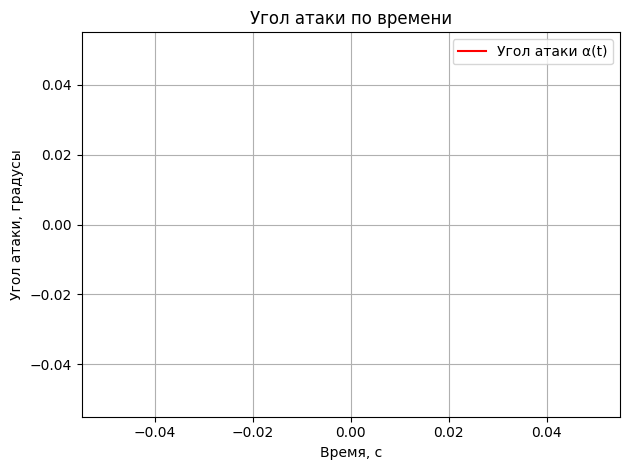

In [3]:
plt.plot(ballistics.time_list, ballistics.attack_list, label='Угол атаки α(t)', color='red')
plt.xlabel('Время, с')
plt.ylabel('Угол атаки, градусы')
plt.title('Угол атаки по времени')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

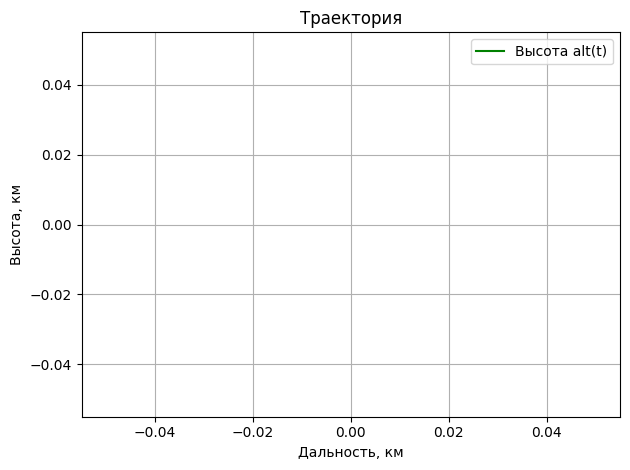

In [4]:
plt.plot(ballistics.long_list, ballistics.alt_list, label='Высота alt(t)', color='green')
plt.xlabel('Дальность, км')
plt.ylabel('Высота, км')
plt.title('Траектория')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

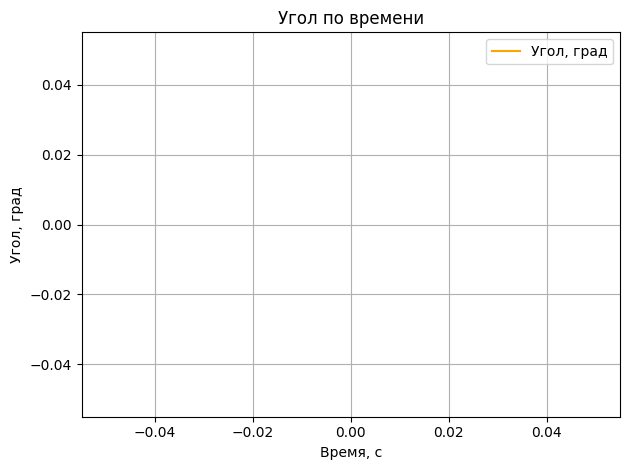

In [5]:
plt.plot(ballistics.time_list, ballistics.traj_list, label='Угол, град', color='orange')
plt.xlabel('Время, с')
plt.ylabel('Угол, град')
plt.title('Угол по времени')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()